In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

## intial setep

In [3]:
sales=pd.read_csv("daily_sales_french_bakery.csv",parse_dates=["ds"])
sales.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [4]:
sales.shape


(57046, 4)

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57046 entries, 0 to 57045
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   unique_id   57046 non-null  object        
 1   ds          57046 non-null  datetime64[ns]
 2   y           57046 non-null  float64       
 3   unit_price  57046 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.7+ MB


In [6]:
sales.isnull().sum()

unique_id     0
ds            0
y             0
unit_price    0
dtype: int64

In [7]:
sales.duplicated().sum()

np.int64(0)

In [8]:
sales=sales.groupby("unique_id").filter(lambda x: len(x)>=28)
sales=sales.drop(["unit_price"],axis=1)
sales.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


In [9]:
sales['unique_id'].value_counts()

unique_id
BAGUETTE              637
BOULE 400G            637
BANETTE               637
BOULE 200G            637
BANETTINE             637
                     ... 
RELIGIEUSE             71
SABLE F  P             68
DELICETROPICAL         63
VIENNOISE              61
PAIN SUISSE PEPITO     51
Name: count, Length: 121, dtype: int64

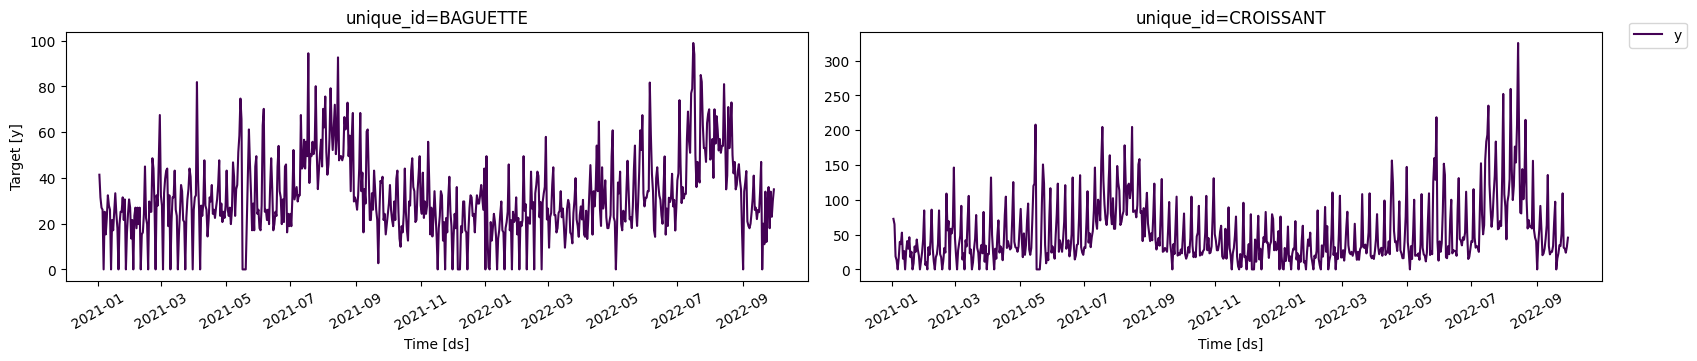

In [10]:
plot_series(df=sales,ids=["BAGUETTE", "CROISSANT"],palette="viridis")


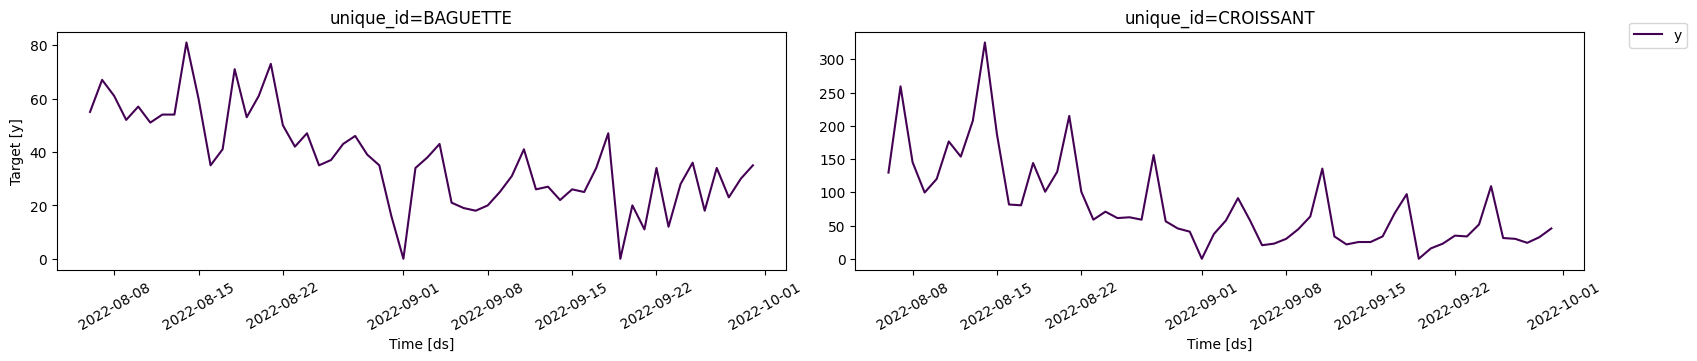

In [11]:
plot_series(df=sales, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

## Baseline Models

In [12]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [13]:
horizon=7
models=[
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=10),
    SeasonalNaive(season_length=7),
]
sf=StatsForecast(
    models=models,
    freq="D",
)
sf.fit(df=sales)
preds = sf.predict(h=horizon)
preds.head()


,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.0,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.0,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.0,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.0,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.0,0.0


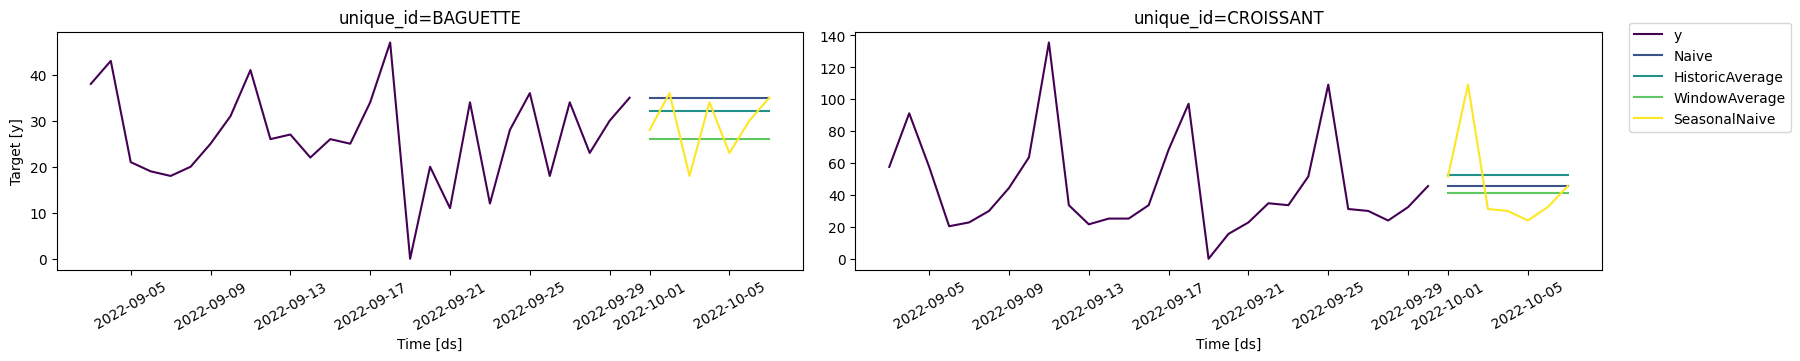

In [14]:
plot_series(
    df=sales, 
    forecasts_df=preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")

## Evalution of baseline models

In [15]:
test = sales.groupby("unique_id").tail(7)
train = sales.drop(test.index).reset_index(drop=True)
sf.fit(df=train)

preds = sf.predict(h=horizon)

eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])
evaluation = evaluate(
    eval_df,
    metrics=[mae],
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.285714,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.528571,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.450000,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,3.200000,0.200000
4,BANETTE,mae,1.314286,5.421984,6.571429,7.885714


In [16]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,4.999752,4.613636


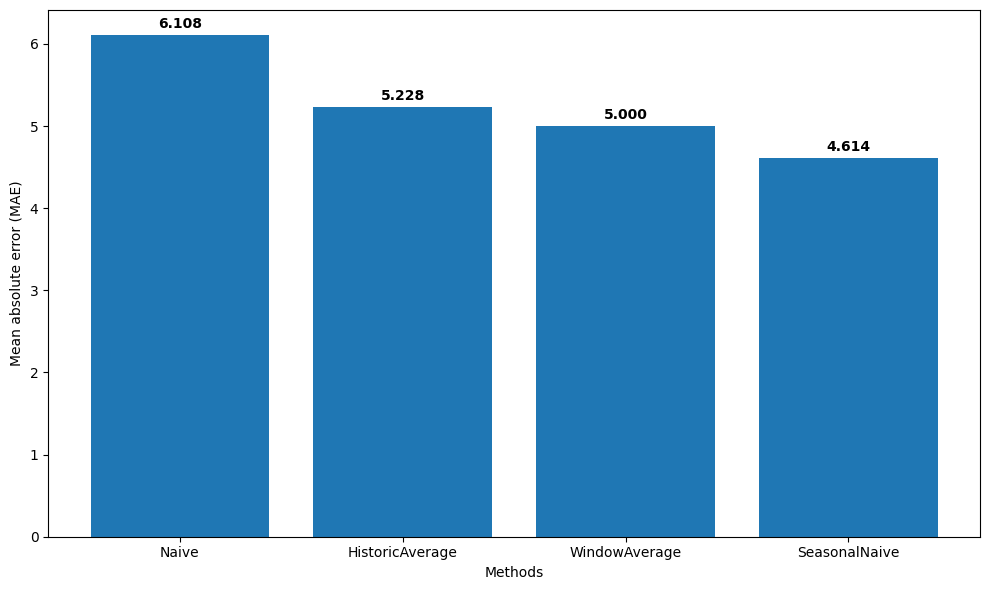

In [17]:
methods = evaluation.columns[1:].tolist()  
values = evaluation.iloc[0, 1:].tolist() 
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## Auto_Arima

In [18]:
from statsforecast.models import AutoARIMA

In [19]:
unique_ids = ["BAGUETTE", "CROISSANT"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.528571,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,17.777143,12.857143


In [20]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,12.652857,12.714286


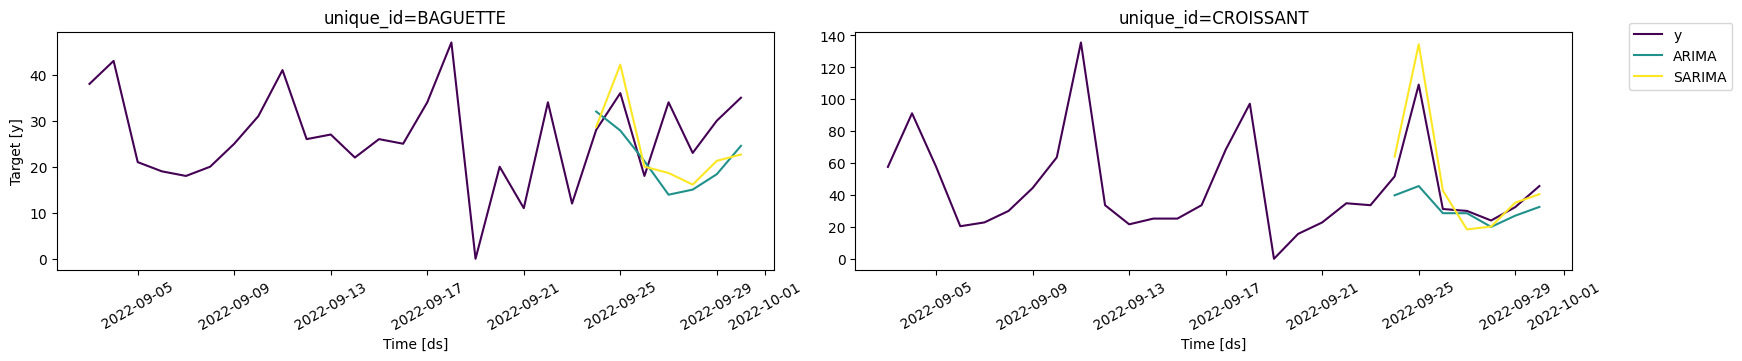

In [22]:
plot_series(
    df=sales, 
    forecasts_df=arima_preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")

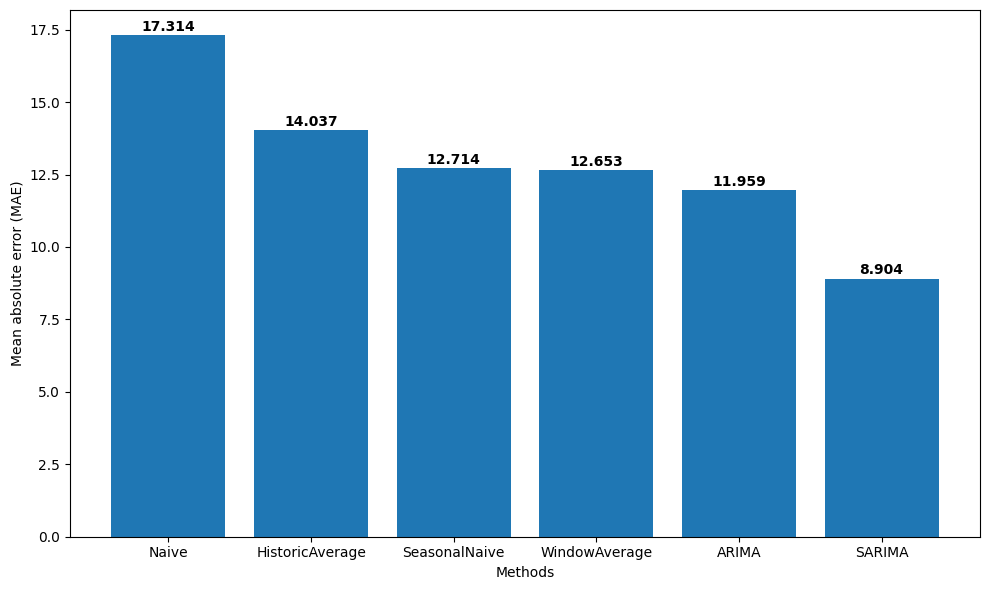

In [23]:
methods = arima_eval.columns[1:].tolist()  
values = arima_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()